In [65]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim # For gradient descent

# This is the function that will be used to generate the truth data.
def truth_func(x1, x2):
    """
    Compute a piecewise function value based on inputs x1 and x2.
    
    Parameters:
    - x1, x2: Inputs for which the function value needs to be computed.
    
    Returns:
    - Function value based on the given conditions.
    - This function returns two values, y1 and y2.
    """
    
    # Check bounds for x1 and x2
    if not (-1 <= x1 <= 1) or not (-1 <= x2 <= 1):
        raise ValueError('Both x1 and x2 must be in the range [-1, 1]')

    # Determine the function value of y1
    if x1 >= 0:
        if x2 >= 0:
            y1 = (x1-0.5)**2 + (x2-0.5)**2
        else:
            y1 = np.sin(x1) + np.sin(x2)
    else:
        if x2 >= 0:
            y1 = 0 if x1 < -0.5 else 1
        else:
            y1 = abs(x1 + 0.5) + abs(x2 + 0.5)
    
    # Determine the function value of y2

    y2 = np.sinc(3*(x1**2) + 3*(x2**2)) * 10

    return y1, y2

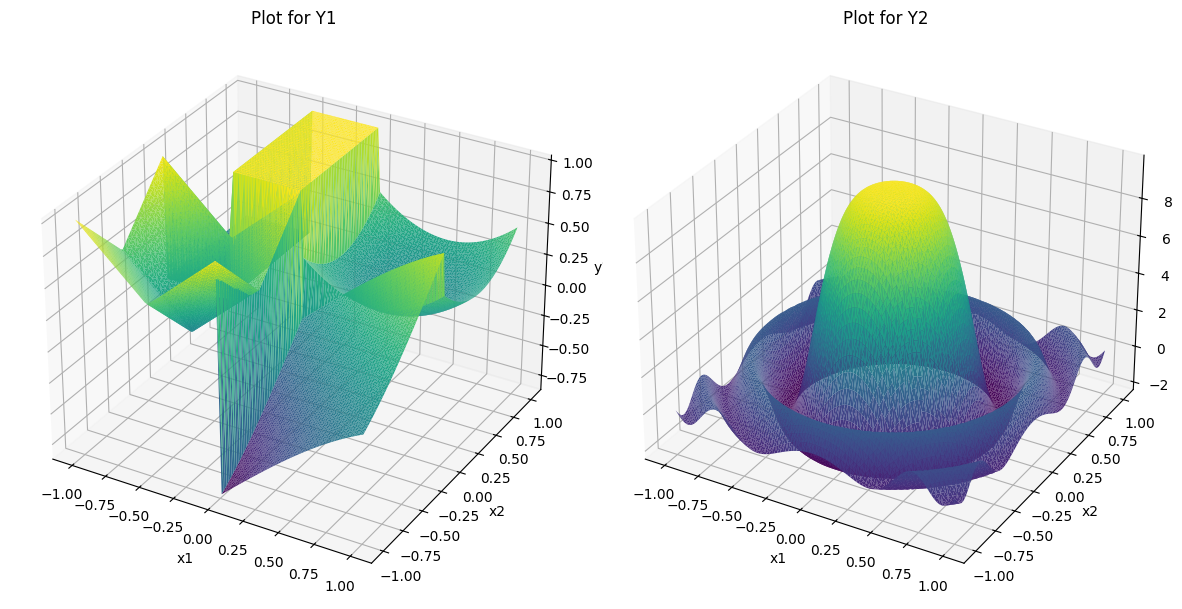

In [66]:
#Lets plot this function to see what it looks like.
# Generate the data points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1_points = []
X2_points = []
Y1_points = []
Y2_points = []

for x1_i in x1:
    for x2_i in x2:
        X1_points.append(x1_i)
        X2_points.append(x2_i)

        y1_i, y2_i = truth_func(x1_i, x2_i)
        Y1_points.append(y1_i)
        Y2_points.append(y2_i)


# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_points, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y1')
ax1.set_title('Plot for Y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_points, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title('Plot for Y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()

In [67]:
# Create training data for the neural network

num_train_data = 10000

# Generating random x and y values at once
x1_values = np.random.uniform(-1, 1, num_train_data)
x2_values = np.random.uniform(-1, 1, num_train_data)

# Stack them together for the input array
train_inputs = np.vstack((x1_values, x2_values)).T

# Compute the outputs using a vectorized approach
train_outputs = np.array([truth_func(x1, x2) for x1, x2 in zip(x1_values, x2_values)])



In [68]:
# Create testing data for the neural network

num_test_data = 1000 # an order of magnitude smaller than the training data

# Generating random x and y values at once
x1_values = np.random.uniform(-1, 1, num_test_data)
x2_values = np.random.uniform(-1, 1, num_test_data)

# Stack them together for the input array
test_inputs = np.vstack((x1_values, x2_values)).T

# Compute the outputs using a vectorized approach
test_outputs = np.array([truth_func(x1, x2) for x1, x2 in zip(x1_values, x2_values)])



In [69]:
# Uh oh, we have to deal with a quirk of NNs. Typically, NNs should be fed values between -1 and 1. NN will then output a value between 0 and 1.
# This is of course dependent on the activation function used. Generally, it is good practice to normalize the data before feeding it to the NN.

# Luckily, our input data is already normalized so we don't have to worry about that. The ouput data, however, is not normalized. So we need to normalize it.

def normalize_data(y1_data, y2_data, inverse=False):
    """
    Normalize the data to 0 to 1 range. Or, if inverse is True, then denormalize the data to the original range.
    
    Parameters:
    - y1_data: Data for y1.
    - y2_data: Data for y2.

    Returns:
    - Normalized data for y1 and y2.
    """
    # The input data is already in the range [-1, 1], so we just need to normalize the output data
    y1_max = 1.0
    y1_min = -1.0
    y2_max = 10.0
    y2_min = -3.0
    
    if not inverse:
        y1_data_norm = (y1_data - y1_min) / (y1_max - y1_min)
        y2_data_norm = (y2_data - y2_min) / (y2_max - y2_min)
    else:
        y1_data_norm = y1_data * (y1_max - y1_min) + y1_min
        y2_data_norm = y2_data * (y2_max - y2_min) + y2_min

    return y1_data_norm, y2_data_norm

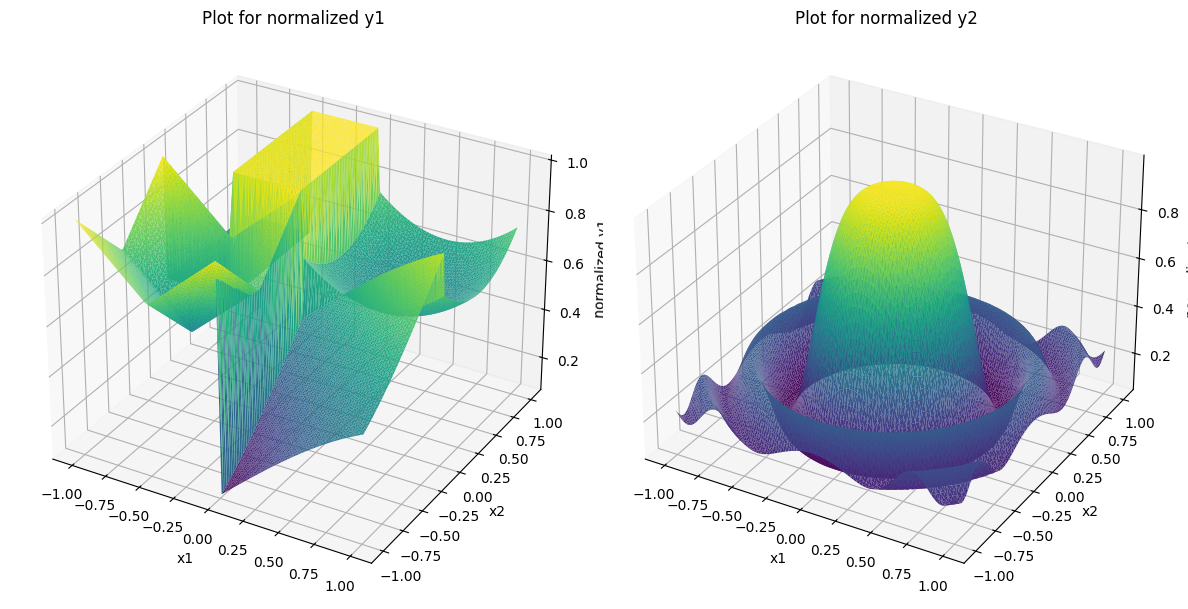

In [70]:
# for plotting purposes, we will normalize Y1_points and Y2_points as well which we plotted earlier

Y1_points_norm, Y2_points_norm = normalize_data(np.array(Y1_points), np.array(Y2_points))

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_points_norm, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('normalized y1')
ax1.set_title('Plot for normalized y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_points_norm, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('normalized y2')
ax2.set_title('Plot for normalized y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()



In [71]:
# Normalize the training and testing data

train_output_1_norm, train_output_2_norm = normalize_data(train_outputs[:, 0], train_outputs[:, 1])
test_output_1_norm, test_output_2_norm = normalize_data(test_outputs[:, 0], test_outputs[:, 1])

# Stack them together for the input array
train_outputs_norm = np.vstack((train_output_1_norm, train_output_2_norm)).T
test_outputs_norm = np.vstack((test_output_1_norm, test_output_2_norm)).T

# Now that the data is normalized, we can convert to tensors
# Tensors are the arrays that PyTorch uses to store data

# Convert numpy arrays to PyTorch tensors
train_inputs_torch = torch.from_numpy(train_inputs).float()
train_outputs_torch = torch.from_numpy(train_outputs_norm).float()
test_inputs_torch = torch.from_numpy(test_inputs).float()
test_outputs_torch = torch.from_numpy(test_outputs_norm).float()

print(train_inputs_torch.shape)
print(train_outputs_torch.shape)
print(test_inputs_torch.shape)
print(test_outputs_torch.shape)


torch.Size([10000, 2])
torch.Size([10000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])


In [72]:
# Lets create a neural network to learn this function.


class DNN(nn.Module):
    def __init__(self, input_size, layer1_size, layer2_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layer1_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(layer2_size, output_size)
        self.act_out = nn.Sigmoid()


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act_out(self.fc3(x))

        return x
    


In [73]:
# Define the loss (or cost) function for the neural network.
# This is the function that measures the difference between
# the predicted outputs and the actual targets, which we want to minimize.
def mse_loss(outputs, targets):
    return torch.mean((outputs - targets)**2)

In [74]:
# We need a way to evallate the DNN. We will feed it a bunch of test data and see what the average loss is from all this data.

# N.B. The testing data must be different from the training data!!! Otherwise, you will only be evaluating the DNN at places it has
# already seen, which is no bueno. Its like making a test for a student consist of entirely problems they have already had on homeworks.

def evaluate(model, test_inputs, test_outputs, loss_function):
    """
    Evaluates the average loss of a model over given test data.
    
    Parameters:
    - model: The neural network model to be evaluated.
    - test_inputs: Tensor of input data for testing.
    - test_outputs: Tensor of target output data for testing.
    - loss_function: The loss function to measure model accuracy.
    
    Returns:
    - Average loss of the model over the test data.
    """
    
    with torch.no_grad(): # disable gradient tracking since we are only evaluating for efficiency
        predictions = model(test_inputs)
        total_loss = loss_function(predictions, test_outputs)
        
    return total_loss.item() / test_inputs.size(0)


In [75]:
# Create the neural network with specified sizes for each layer
input_size = 2
layer1_size = 128
layer2_size = 64
output_size = 2

model = DNN(input_size, layer1_size, layer2_size, output_size)

# Print the model architecture to understand its structure
print(model)

# Create the optimizer for training the neural network.
# The Adam optimizer is a popular choice due to its adaptive learning rate capabilities.
# We start with a learning rate of 0.001, which is a common starting point, but this can be tuned.
optimizer = optim.Adam(model.parameters(), lr=0.001)

DNN(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (act_out): Sigmoid()
)


In [76]:
num_of_training_points = train_inputs_torch.size(0)

num_of_training_epochs = 1000 # an epoch is one pass through the entire training data

frequency_of_eval = 100 # How often to evaluate the model. Unit is steps not epochs. Sowe evaluate every 500 steps.
                    # one step is one batch of data fed to the model
evaluation_results = [] # List to store the evaluation results
min_eval_loss = np.inf # Variable to keep track of the lowest evaluation loss

total_steps = 0 # Keeps track of the total number of steps taken during training. 
                # One step is one batch of data fed to the model.
batch_size = 64 # We don't train the NN every timestep, we train it in batches. This is the size of each batch.
num_batches = num_of_training_points // batch_size 

for epoch in range(num_of_training_epochs):

    # Shuffle the data at the start of each epoch
    permutation = torch.randperm(num_of_training_points)
    training_data_inputs_shuffled = train_inputs_torch[permutation]
    training_data_outputs_shuffled = train_outputs_torch[permutation]

    for i in range(num_batches):

        # Start and end indices for the current batch
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        # Fetch the current batch
        inputs_batch = training_data_inputs_shuffled[start_idx:end_idx]
        targets_batch = training_data_outputs_shuffled[start_idx:end_idx]

        # Feed the input batch to the model
        outputs_batch = model(inputs_batch)

        # Calculate the loss for the current batch
        loss = mse_loss(outputs_batch, targets_batch)

        # Zero out any old gradients
        optimizer.zero_grad()

        # Calculate the gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        total_steps += 1

        # Evaluation
        if total_steps % frequency_of_eval == 0:
            eval_res = evaluate(model, test_inputs_torch, test_outputs_torch, mse_loss)
            evaluation_results.append(eval_res)
            print(f'Step: {total_steps} \t Evaluation loss: {eval_res}')

            if eval_res < min_eval_loss:
                min_eval_loss = eval_res
                torch.save(model.state_dict(), 'best_model.pt')


Step: 100 	 Evaluation loss: 3.162834420800209e-05
Step: 200 	 Evaluation loss: 2.1129393950104713e-05
Step: 300 	 Evaluation loss: 1.6263509169220926e-05
Step: 400 	 Evaluation loss: 1.324092410504818e-05
Step: 500 	 Evaluation loss: 1.1107057332992553e-05
Step: 600 	 Evaluation loss: 9.332634508609772e-06
Step: 700 	 Evaluation loss: 7.862098515033722e-06
Step: 800 	 Evaluation loss: 6.70316768810153e-06
Step: 900 	 Evaluation loss: 6.047704257071018e-06
Step: 1000 	 Evaluation loss: 5.606792401522398e-06
Step: 1100 	 Evaluation loss: 5.293330643326044e-06
Step: 1200 	 Evaluation loss: 4.7704456374049185e-06
Step: 1300 	 Evaluation loss: 4.51158219948411e-06
Step: 1400 	 Evaluation loss: 4.461572039872408e-06
Step: 1500 	 Evaluation loss: 4.141743760555982e-06
Step: 1600 	 Evaluation loss: 4.0251542814075945e-06
Step: 1700 	 Evaluation loss: 3.6677587777376176e-06
Step: 1800 	 Evaluation loss: 3.6202375777065753e-06
Step: 1900 	 Evaluation loss: 3.5155972000211477e-06
Step: 2000 	 Ev

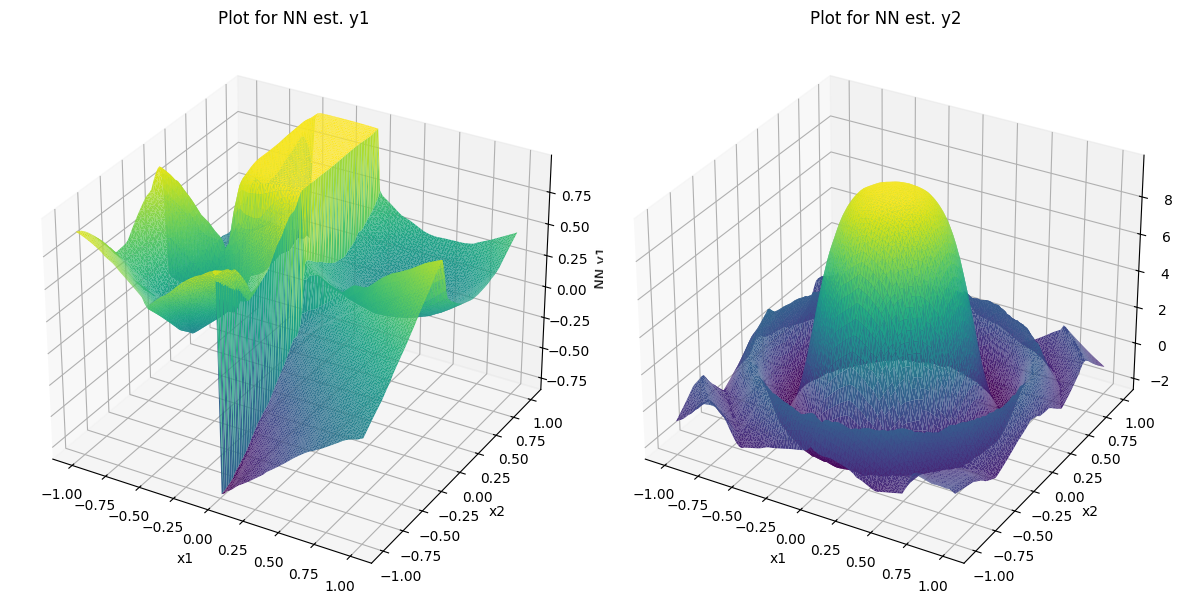

In [77]:
# lets plot the output of the neural network and compare it to the truth function.

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Generate the data points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1_points_NN = []
X2_points_NN = []
Y1_points_NN = []
Y2_points_NN = []


for x1_i in x1:
    for x2_i in x2:
        X1_points_NN.append(x1_i)
        X2_points_NN.append(x2_i)

        output = model(torch.Tensor([x1_i, x2_i]))
        y1_i, y2_i = normalize_data(output[0].item(), output[1].item(), inverse=True) 

        Y1_points_NN.append(y1_i)
        Y2_points_NN.append(y2_i)


# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points_NN, X2_points_NN, Y1_points_NN, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('NN y1')
ax1.set_title('Plot for NN est. y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points_NN, X2_points_NN, Y2_points_NN, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('NN y2')
ax2.set_title('Plot for NN est. y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()

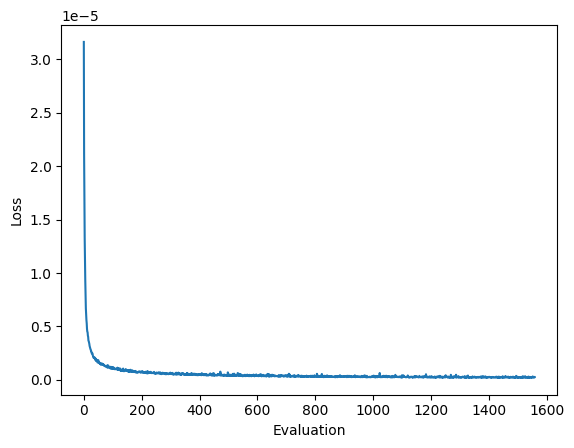

In [78]:
# Lets plot the loss function over time to see how it changes.

# Plot the evaluation results
plt.plot(evaluation_results)
plt.xlabel('Evaluation')
plt.ylabel('Loss')
plt.show()

0.909257173538208 1.0
0.9021404981613159 0.9797979797979798
0.8944966793060303 0.9595959595959596
0.8851101398468018 0.9393939393939394
0.8725148439407349 0.9191919191919192
0.8586428165435791 0.898989898989899
0.8433876037597656 0.8787878787878788
0.8266390562057495 0.8585858585858586
0.8082760572433472 0.8383838383838383
0.7890586853027344 0.8181818181818181
0.7684824466705322 0.797979797979798
0.7499251365661621 0.7777777777777778
0.7319232225418091 0.7575757575757576
0.7128132581710815 0.7373737373737373
0.6925739049911499 0.7171717171717171
0.6711821556091309 0.696969696969697
0.6496611833572388 0.6767676767676767
0.6198098659515381 0.6565656565656566
0.5913835763931274 0.6363636363636364
0.5614169836044312 0.6161616161616161
0.535260796546936 0.5959595959595959
0.5273919105529785 0.5757575757575757
0.5291508436203003 0.5555555555555556
0.5309057235717773 0.5353535353535352
0.5326560735702515 0.5151515151515151
0.5344021320343018 0.5050505050505051
0.5361429452896118 0.52525252525

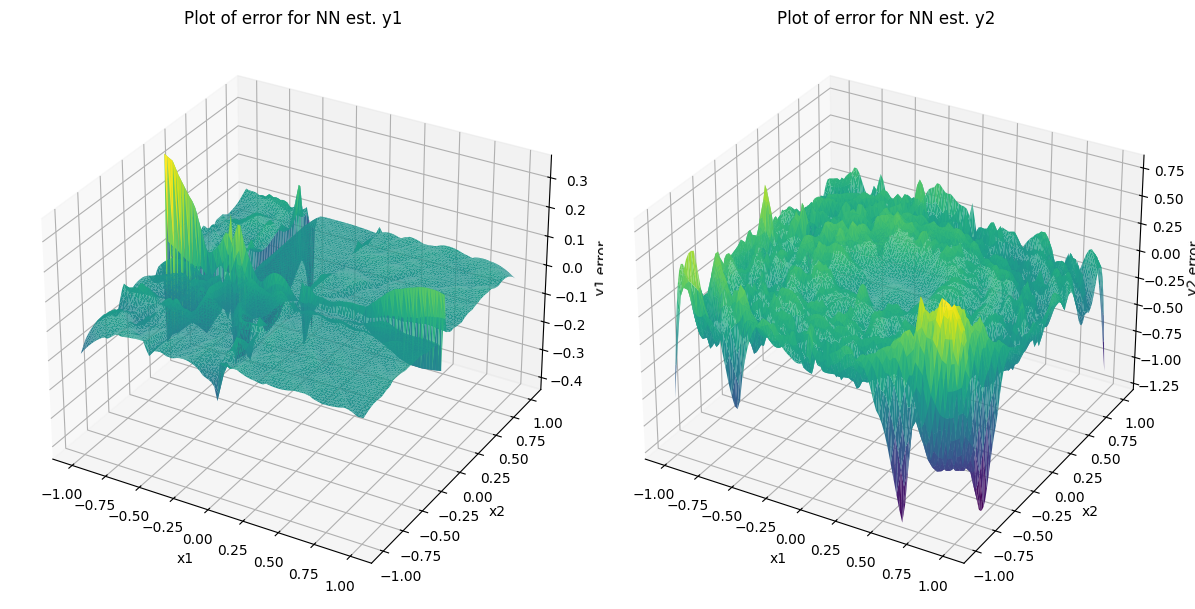

In [79]:
# Let's plot error 

Y1_error = []
Y2_error = []

for i in range(len(Y1_points_NN)):
    print(Y1_points_NN[i], Y1_points[i])
    Y1_error.append(Y1_points_NN[i] - Y1_points[i])
    Y2_error.append(Y2_points_NN[i] - Y2_points[i])

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_error, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y1 error')
ax1.set_title('Plot of error for NN est. y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_error, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2 error')
ax2.set_title('Plot of error for NN est. y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()